In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import sys

WORKING_DIR = '/content/drive/MyDrive/Colab/low_light'
sys.path.append(WORKING_DIR)

In [3]:
from tqdm import tqdm
import time
import glob
import numpy as np
import torch
import utils
from PIL import Image
import logging
import argparse
import torch.utils
import torch.backends.cudnn as cudnn
import torch.nn as nn
from torch.autograd import Variable
from torchsummary import summary

from model import *
from multi_read_data import MemoryFriendlyLoader

<h1>Constants & Utility

In [5]:
BATCH_SIZE = 1
SEED = 42
EPOCHS = 100
LEARN_RATE = 0.0003
NUM_STAGE = 3

SESSION_NAME = 'test'
SAVE_DIR = os.path.join(WORKING_DIR, SESSION_NAME)

In [ ]:
def save_images(tensor, path):
    image_numpy = tensor[0].cpu().float().numpy()
    image_numpy = (np.transpose(image_numpy, (1, 2, 0)))
    im = Image.fromarray(np.clip(image_numpy * 255.0, 0, 255.0).astype('uint8'))
    im.save(path, 'png')

<h1>Training

In [ ]:
if torch.cuda.is_available():
    torch.set_default_dtype(torch.float)
else:
    print("WARNING: CUDA not available.")

In [ ]:
utils.create_exp_dir(SAVE_DIR, scripts_to_save=glob.glob(os.path.join(WORKING_DIR, '*.py')))
model_path = SAVE_DIR + '/model_epochs/'
os.makedirs(model_path, exist_ok=True)
image_path = SAVE_DIR + '/image_epochs/'
os.makedirs(image_path, exist_ok=True)

Experiment dir : /content/drive/MyDrive/Colab/low_light/test


In [ ]:
np.random.seed(SEED)
cudnn.benchmark = True
torch.manual_seed(SEED)
cudnn.enabled = True
torch.cuda.manual_seed(SEED)

In [ ]:
model = TrainModel(stage=NUM_STAGE)

model.illumination.in_conv.apply(model.weights_init)
model.illumination.conv.apply(model.weights_init)
model.illumination.out_conv.apply(model.weights_init)
model.self_calibrate.in_conv.apply(model.weights_init)
model.self_calibrate.convs.apply(model.weights_init)
model.self_calibrate.out_conv.apply(model.weights_init)

model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARN_RATE, betas=(0.9, 0.999), weight_decay=3e-4)
MB = utils.count_parameters_in_MB(model)
print(MB)

0.005189


In [ ]:
train_low_data_names = '/content/drive/MyDrive/Colab/data/dark_images'
TrainDataset = MemoryFriendlyLoader(img_dir=train_low_data_names, task='train')


test_low_data_names = '/content/drive/MyDrive/Colab/data/dark_test'
TestDataset = MemoryFriendlyLoader(img_dir=test_low_data_names, task='test')

train_queue = torch.utils.data.DataLoader(TrainDataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=0, shuffle=True)

test_queue = torch.utils.data.DataLoader(TestDataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=0, shuffle=True)

In [ ]:
total_step = 0

for epoch in tqdm(range(EPOCHS), desc="Epoch", position=0):
    model.train()
    losses = []
    for batch_idx, (input, _) in enumerate(train_queue):
        total_step += 1
        input = Variable(input, requires_grad=False).cuda()

        optimizer.zero_grad()
        loss = model._loss(input)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()

        losses.append(loss.item())

    utils.save(model, os.path.join(model_path, 'weights_%d.pt' % epoch))

    if (epoch % 10 == 0 or epoch == EPOCHS - 1) and total_step != 0:
        model.eval()
        with torch.no_grad():
            for _, (input, image_name) in enumerate(test_queue):
                input = Variable(input, volatile=True).cuda()
                image_name = image_name[0].split('/')[-1].split('.')[0]
                illu_list, ref_list, input_list, atten= model(input)
                u_name = '%s.png' % (image_name + '_' + str(epoch))
                u_path = os.path.join(image_path, u_name)
                save_images(ref_list[0], u_path)

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-16-082d60bb5bb9>:24: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  input = Variable(input, volatile=True).cuda()
Epoch: 100%|██████████| 100/100 [3:10:27<00:00, 114.27s/it]


<h1>Utility

In [6]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [18]:
def show_epoch_result(name, epoch):
  original_image = Image.open(os.path.join('/content/drive/MyDrive/Colab/data/dark_test', name))
  epoch_image = Image.open(os.path.join(SAVE_DIR, 'image_epochs', f"{name.split('.')[0]}_{epoch}.png"))

  fig = plt.figure(figsize=(12, 8))

  ax1 = fig.add_subplot(1, 2, 1)
  ax1.imshow(original_image)
  ax1.axis('off')
  ax1.set_title('Original')

  ax2 = fig.add_subplot(1, 2, 2)
  ax2.imshow(epoch_image)
  ax2.axis('off')
  ax2.set_title(f'Epoch {epoch}')

  plt.tight_layout()
  plt.show()

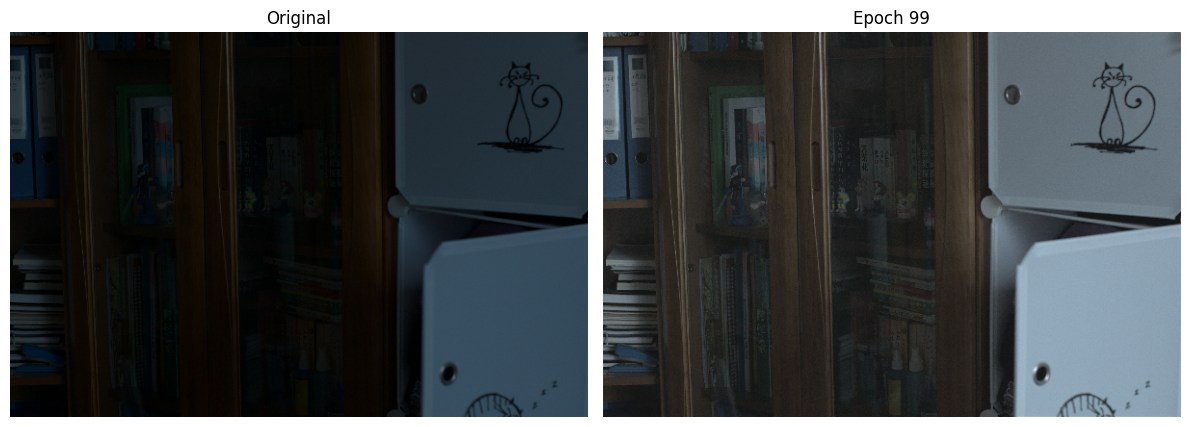

In [19]:
show_epoch_result('00001.png', 99)

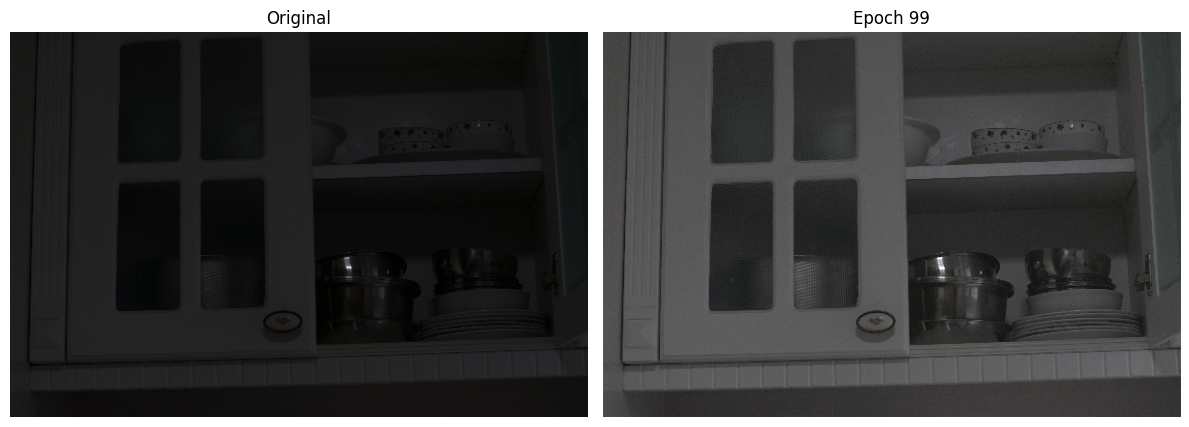

In [20]:
show_epoch_result('00079.png', 99)

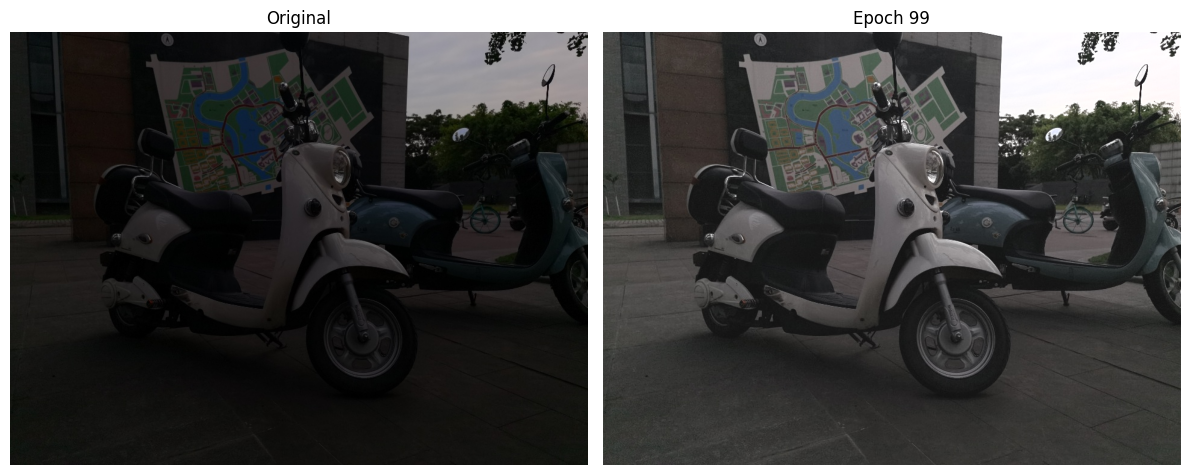

In [23]:
show_epoch_result('2064.jpg', 99)

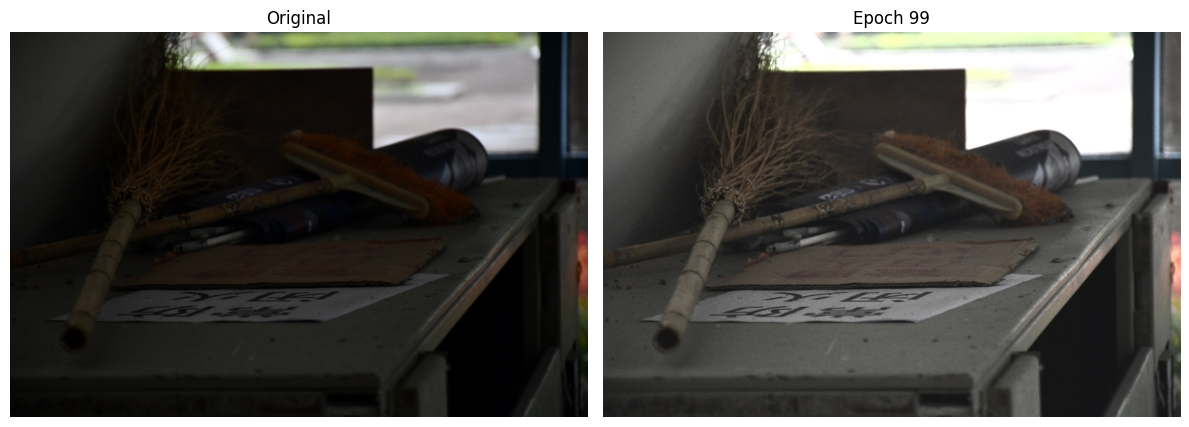

In [22]:
show_epoch_result('3020.jpg', 99)